In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytcspc as pc

%matplotlib inline
%config InlineBackend.figure_format='retina'

d:\Dropbox\code\pytcspc\examples\fit_GP\../../src\pytcspc\sdt.py:34: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# load IRF

we will use the M2 channel

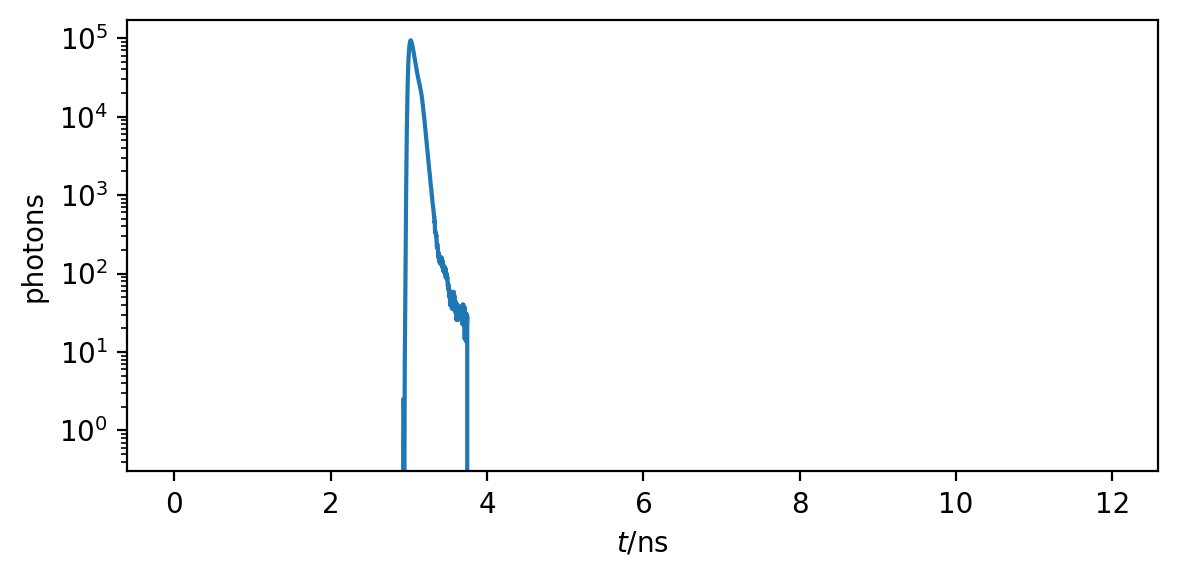

In [2]:
fig, ax = plt.subplots(figsize=(6,3))
irf = pc.load_sdt(r"sample_data/IRF.sdt", dims="CXM", dtype=np.uint32, use_dask=False)

dc_kwargs_M2 = {"trunc": True, "peak_start": 2.93, "peak_end": 3.75, "bgsub": True, "bg_start": 8, "bg_end": 10, "fig": fig, "ax": ax}
fig, ax, irfdc_M2 = pc.decay_curve(irf.sel(channel="M2"), plot=True, **dc_kwargs_M2)
# plt.yscale("linear")

# load data

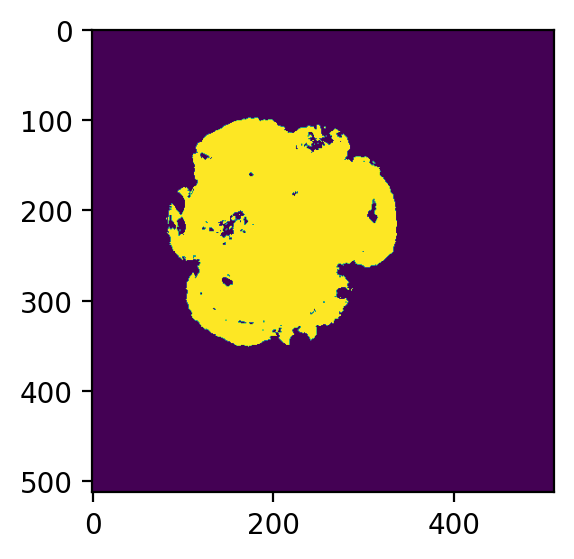

In [3]:
cat_probs = np.load("sample_data/p7_z1_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(use_px)

# load FLIM data

In [4]:
flimg  = pc.load_sdt("sample_data/p7_z3.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
cat_probs = np.load("sample_data/p7_z3_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
dc = pc.decay_curve(flimg, mask=use_px)

# visualize fits for one decay

## least-squares fit

### 2-exp fit
Fit to this model:

$$ F(t) = \mathrm{IRF}(t) \ast \left[ A \cdot \left(  f e^{-t/\tau_1} + (1-f) e^{-t/\tau_2} \right) + \left( 1 - A \right)  \right] $$

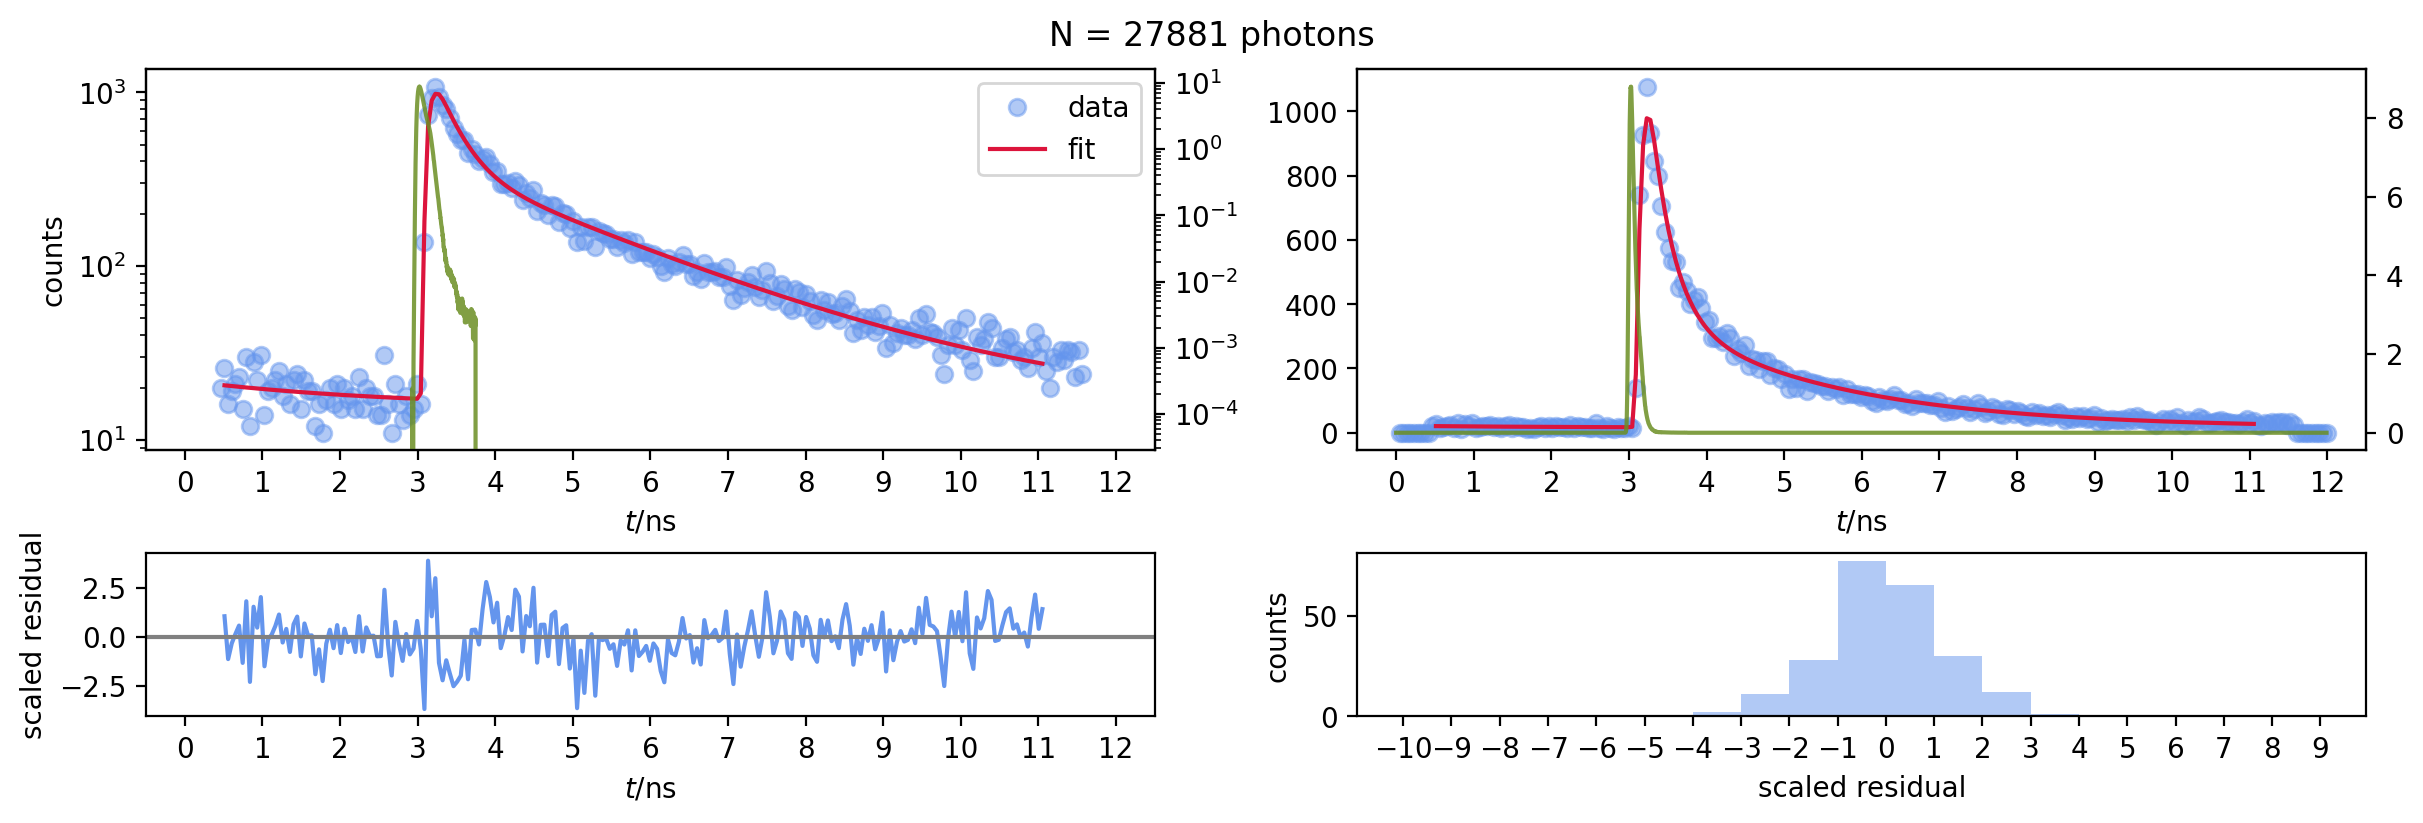

,value,err,min,max,step
shift,22.499998,0.770196,-300.000,300.0,1.000
A,0.988998,0.001668,0.700,1.0,0.001
tau1,2.296028,0.122861,1.000,9.0,0.001
tau2,0.281405,0.014045,0.010,1.0,0.001
f,0.266761,0.010316,0.001,1.0,0.001


In [5]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift": {"value": 0    , "err": np.nan, "min": -300 , "max":   300, "step": 1   },
    "A":     {"value": 0.995, "err": np.nan, "min": 0.700, "max": 1.000, "step": 1e-3},
    "tau1":  {"value": 1.8,   "err": np.nan, "min": 1.000, "max": 9.000, "step": 1e-3},
    "tau2":  {"value": 0.25,  "err": np.nan, "min": 0.010, "max": 1.000, "step": 1e-3},
    "f":     {"value": 0.25,  "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
}

fit_result, fit_status = dg.fit(model="2exp", parameters=parameters, plot=True)
display(fit_result)

### 3-exp fit
Fit to this model:

$$ F(t) = \mathrm{IRF}(t) \ast \left[ A \cdot \left(  f_1 e^{-t/\tau_1} + (1 - f_1) \left( f_2 e^{-t/\tau_2} + (1-f_2) e^{-t/\tau_3} \right) \right) + \left( 1 - A \right)  \right] $$

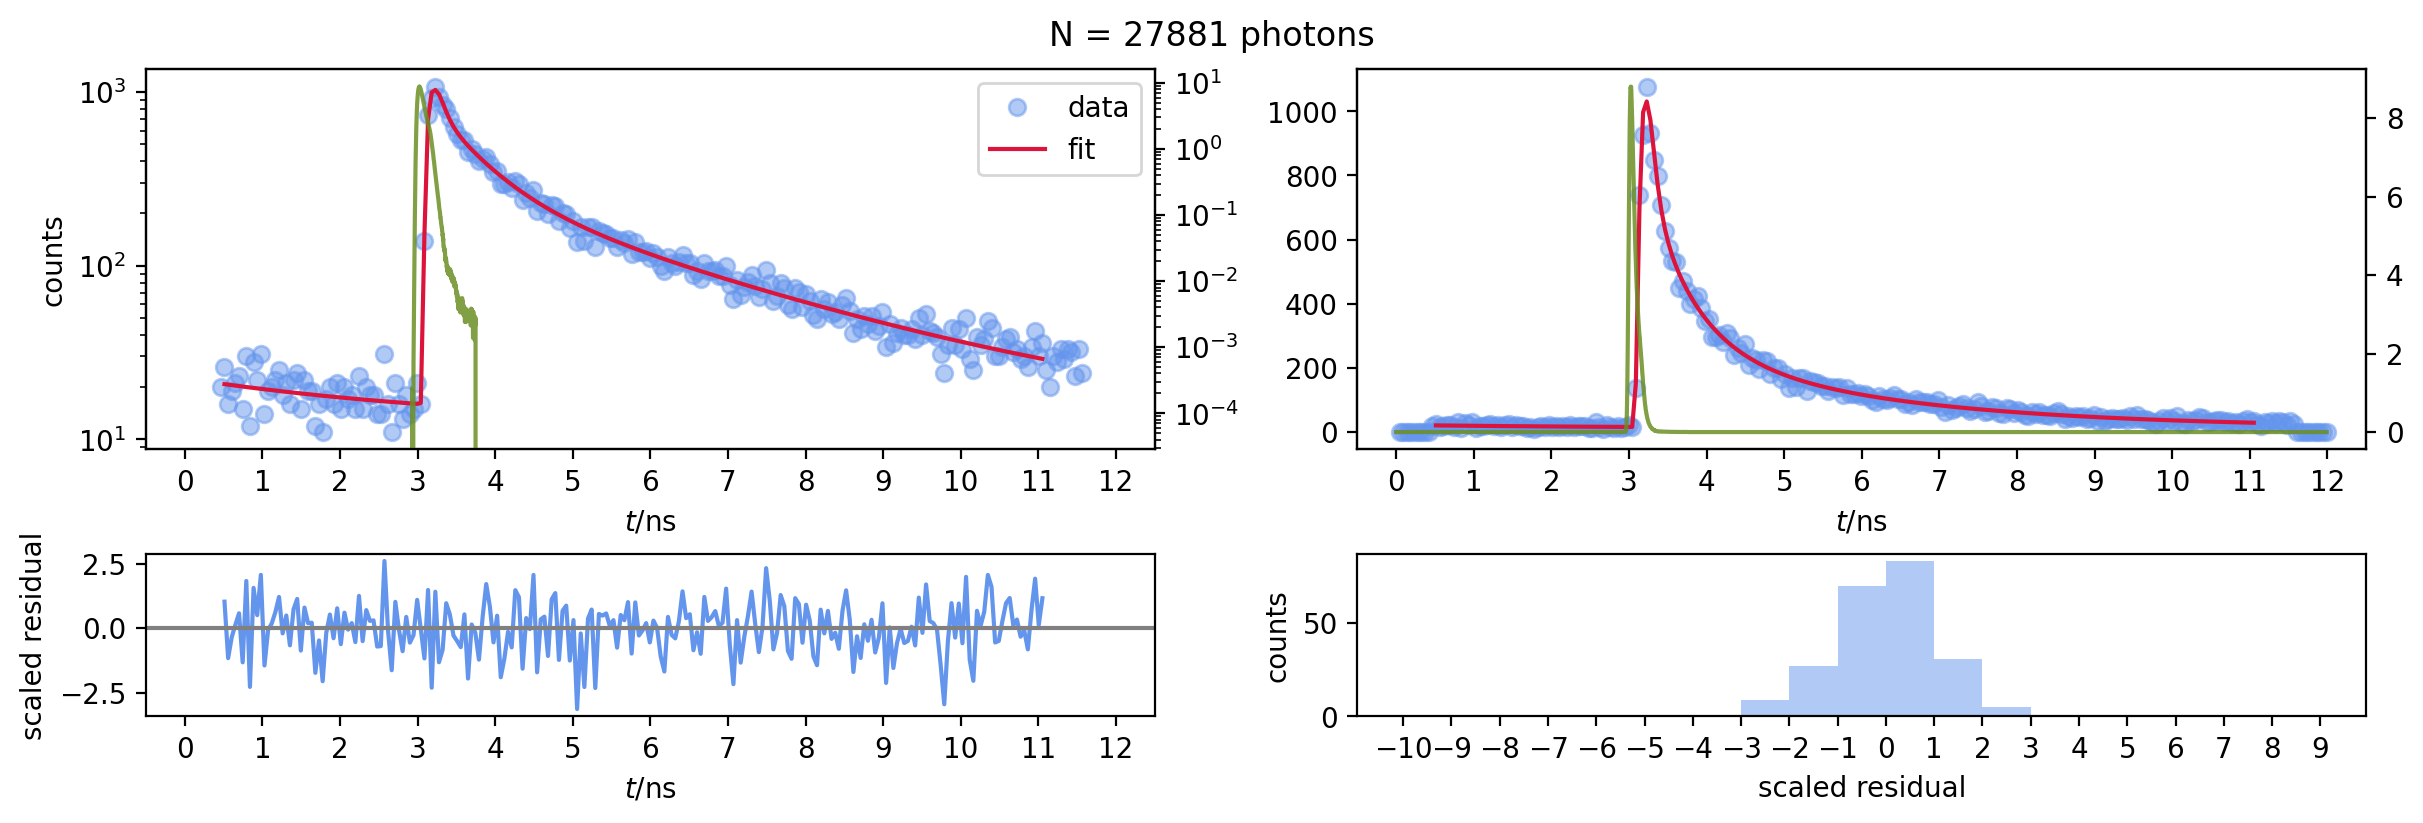

,value,err,min,max,step
shift,25.499997,0.795563,-300.00,300.0,1.000
A,0.993694,0.001275,0.70,1.0,0.001
tau1,2.799689,0.258880,1.00,9.0,0.001
tau2,0.575478,0.057785,0.01,1.0,0.001
tau3,0.078837,0.008652,0.01,1.0,0.001
f1,0.138059,0.013558,0.01,1.0,0.001
f2,0.329982,0.016687,0.01,1.0,0.001


In [6]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift": {"value": 0    , "err": np.nan, "min": -300 , "max":   300, "step": 1   },
    "A":     {"value": 0.995, "err": np.nan, "min": 0.700, "max": 1.000, "step": 1e-3},
    "tau1":  {"value": 2.75,  "err": np.nan, "min": 1.000, "max": 9.000, "step": 1e-3},
    "tau2":  {"value": 0.5,   "err": np.nan, "min": 0.010, "max": 1.000, "step": 1e-3},
    "tau3":  {"value": 0.1,   "err": np.nan, "min": 0.010, "max": 1.000, "step": 1e-3},
    "f1":    {"value": 0.15,  "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
    "f2":    {"value": 0.25,  "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
}

fit_result, fit_status = dg.fit(model="3exp", parameters=None, plot=True)
display(fit_result)

### polyexp fit

To account for some amount of conformational (and therefore lifetime) heterogeneity within each state, we can assume that each state is not associated with a single lifetime, but a narrow distribution of lifetimes.
We model the lifetime distribution as a sum of $ N $ different exponentials with different (fixed) lifetimes, where the weight associated with each exponential is given by the sum of $ n $ Gaussians, with location parameters $ \mu_i $ and scale parameters $ \sigma_i $.

The overall decay function is then:
$$ F(t) = \mathrm{IRF}(t) \ast \left[ A \cdot \left( \sum_i^{N} \sum_j^{n} a_i \dfrac{1}{\sigma_j \sqrt{2 \pi}} \exp \left( -\dfrac{(\tau_i - \mu_j)^2}{2 \sigma_j^2} \right) \exp \left( -t / \tau_i \right) \right) + \left( 1 - A \right)  \right] $$
with the constraint on the amplitudes of the exponentials
$$ \sum_i^n a_j = 1. $$

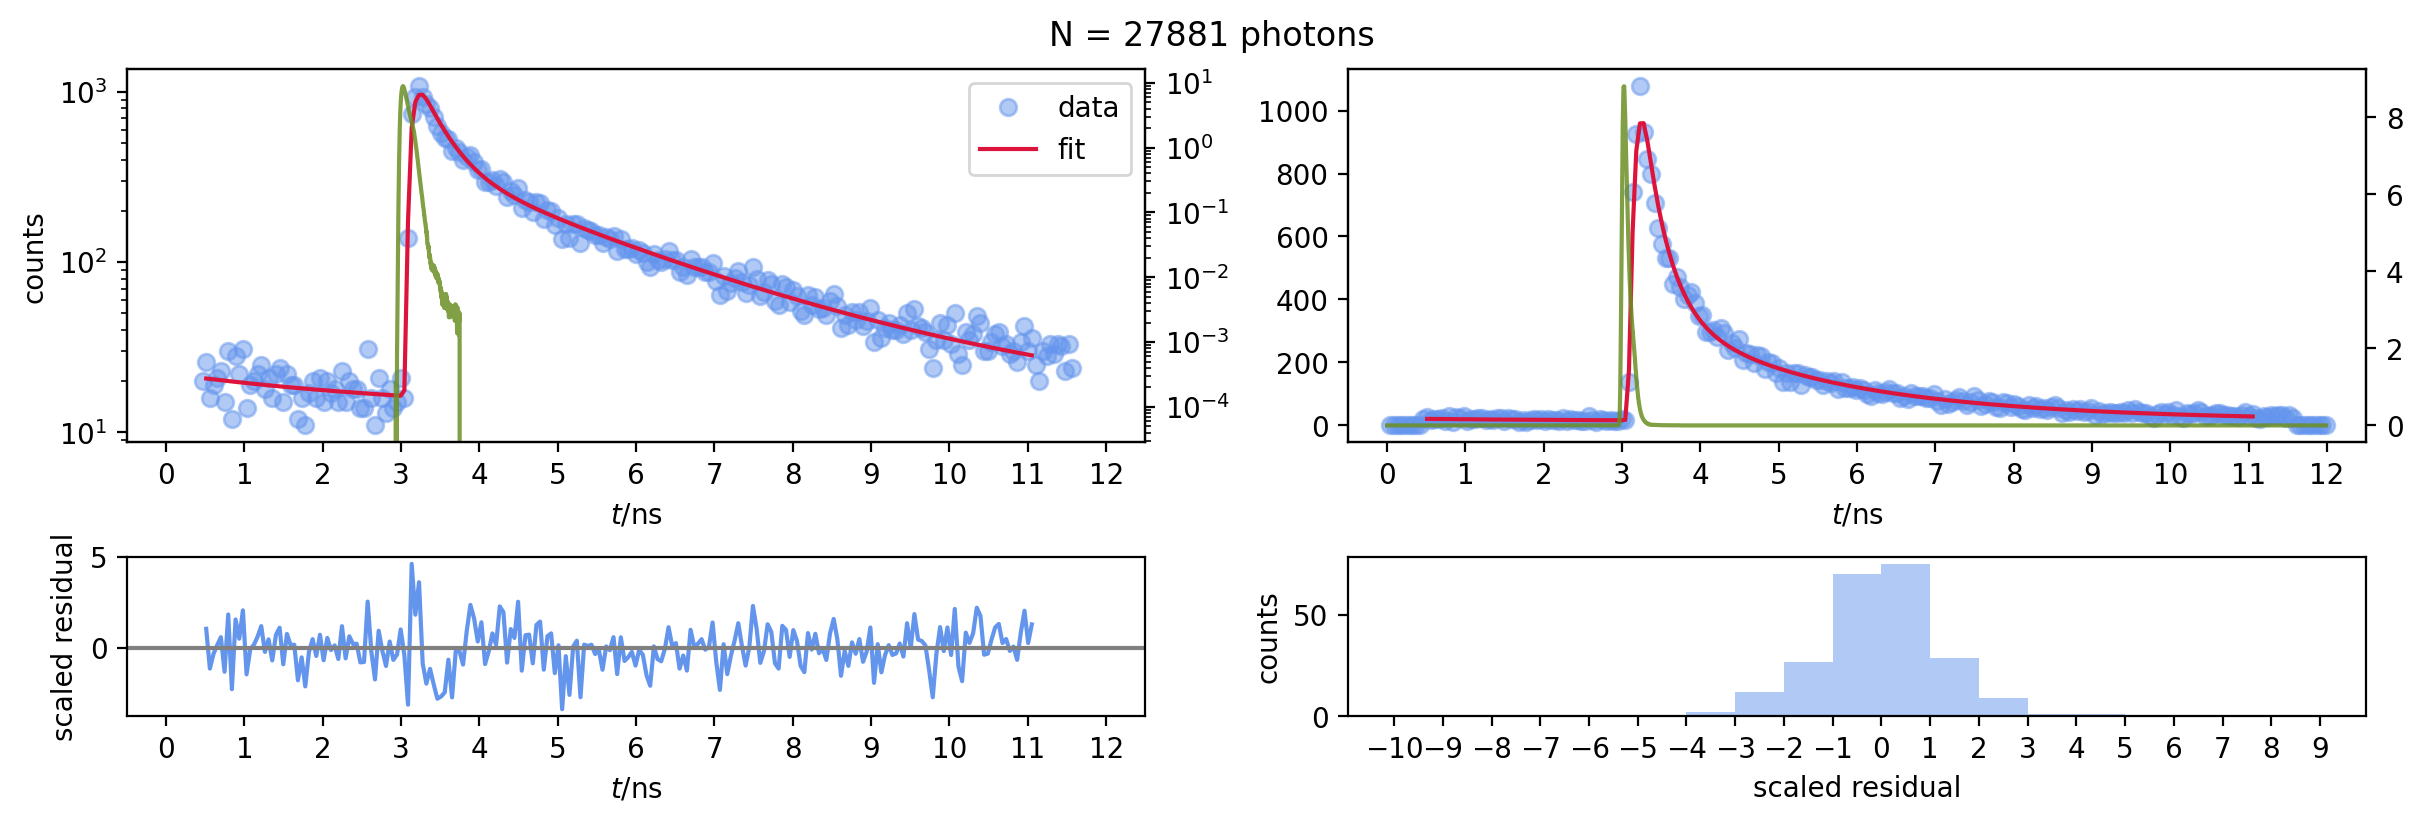

,value,err,min,max,step
shift,21.500004,0.874919,-30.000,30.0,1.000
A,0.986801,0.009194,0.970,1.0,0.001
mu1,2.499906,0.286583,1.000,10.0,0.001
sigma1,1.000000,1.020544,0.001,1.0,0.001
mu2,0.298063,2.860846,0.001,1.0,0.001
sigma2,0.001146,2.304305,0.001,1.0,0.001
amp1,0.039778,0.032841,0.000,1.0,0.001


In [29]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift":  {"value": 0    , "err": np.nan, "min": -30 , "max":   30, "step": 1   },
    "A":      {"value": 0.995, "err": np.nan, "min": 0.97, "max": 1.000, "step": 1e-3},
    "mu1":    {"value": 2.3, "err": np.nan, "min": 1.000, "max": 10.0, "step": 1e-3},
    "sigma1": {"value": 0.001, "err": np.nan, "min": 0.001, "max": 1.0, "step": 1e-3},
    "mu2":    {"value": 0.3, "err": np.nan, "min": 0.001, "max": 1.000, "step": 1e-3},
    "sigma2": {"value": 0.001, "err": np.nan, "min": 0.001, "max": 1.00, "step": 1e-3},
    "amp1":   {"value": 0.25, "err": np.nan, "min": 0.000, "max": 1.00, "step": 1e-3},
}

fit_result, fit_status = dg.fit(model="polyexp", parameters=parameters, plot=True)
display(fit_result)

This does not do that much better than a two-exponential fit. Let's look at the amplitude distribution.

Text(0, 0.5, 'amplitude')

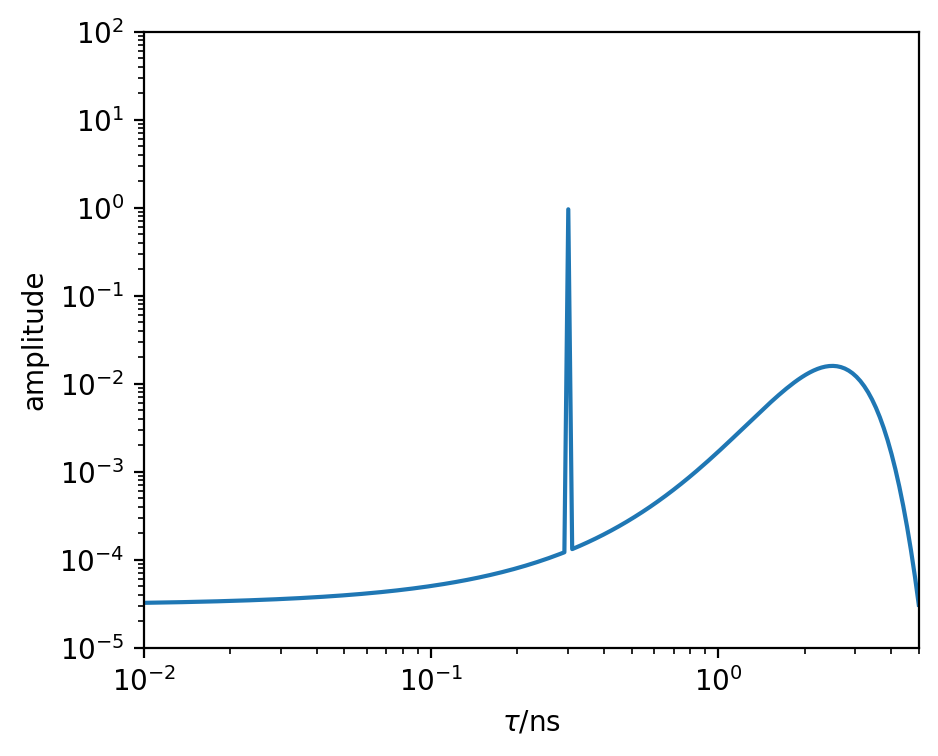

In [42]:
taus = 10**np.linspace(-2, np.log10(5), 200)

amp_dist = pc.amplitude_distribution(taus,
    np.array([fit_result.loc["amp1","value"], 1-fit_result.loc["amp1","value"]]),
    fit_result.loc[["mu1","mu2"],"value"].values,
    fit_result.loc[["sigma1","sigma2"],"value"].values
)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(taus, amp_dist)
ax.set_xscale("log"); ax.set_xlim([1e-2,5e0]); ax.set_xlabel(r"$\tau$/ns")
ax.set_yscale("log"); ax.set_ylim([1e-5,1e2]); ax.set_ylabel(r"amplitude")

## compare least-squares and Gibbs sampling fits

**note that the parameter range needs to restricted for Gibbs sampling -- otherwise evaluation will take too long**. The ranges can be set based on an initial least-squares fit, if desired.

least-squares fit:


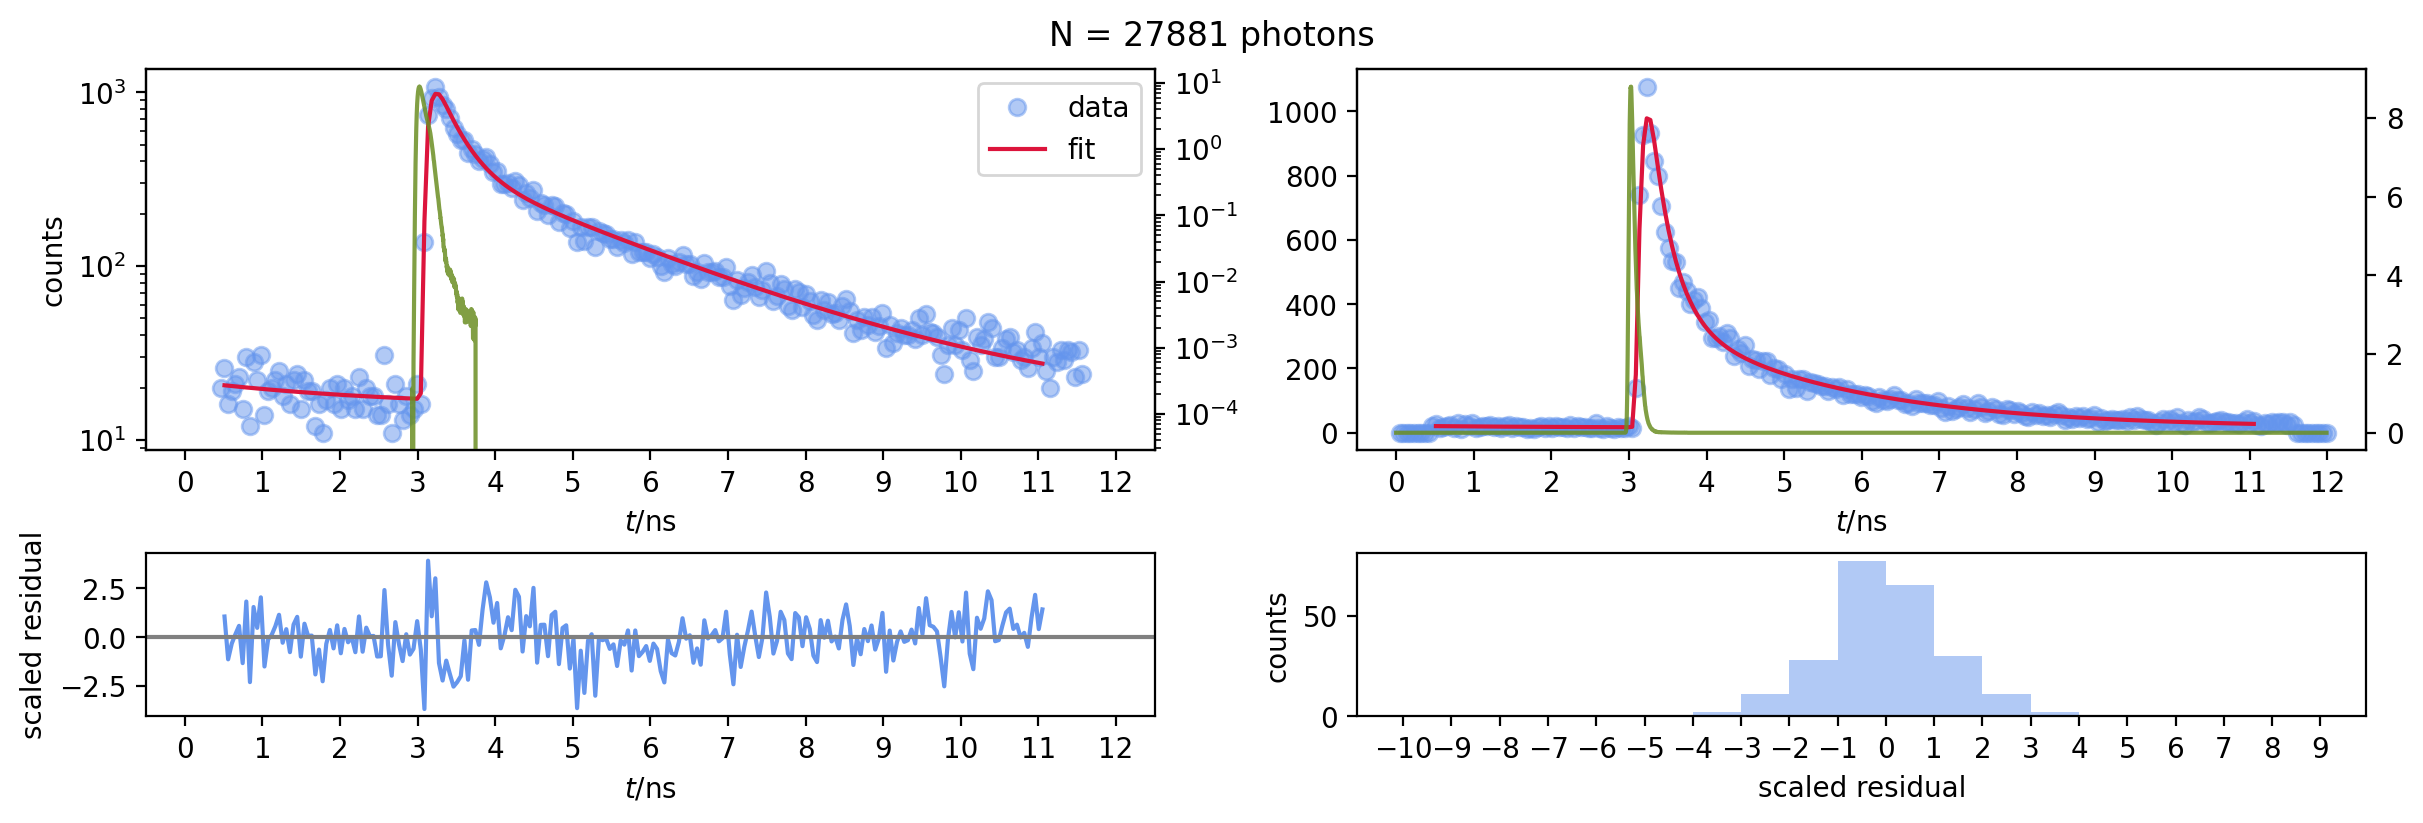

,value,err,min,max,step
shift,22.499997,0.771377,-300.00,300.00,1.000
A,0.988998,0.001675,0.95,1.00,0.001
tau1,2.298866,0.123581,1.50,2.50,0.010
tau2,0.282147,0.014097,0.05,0.80,0.001
f,0.266473,0.010356,0.10,0.35,0.001


Gibbs sampling:


100%|██████████| 2200/2200 [07:09<00:00,  5.12it/s]


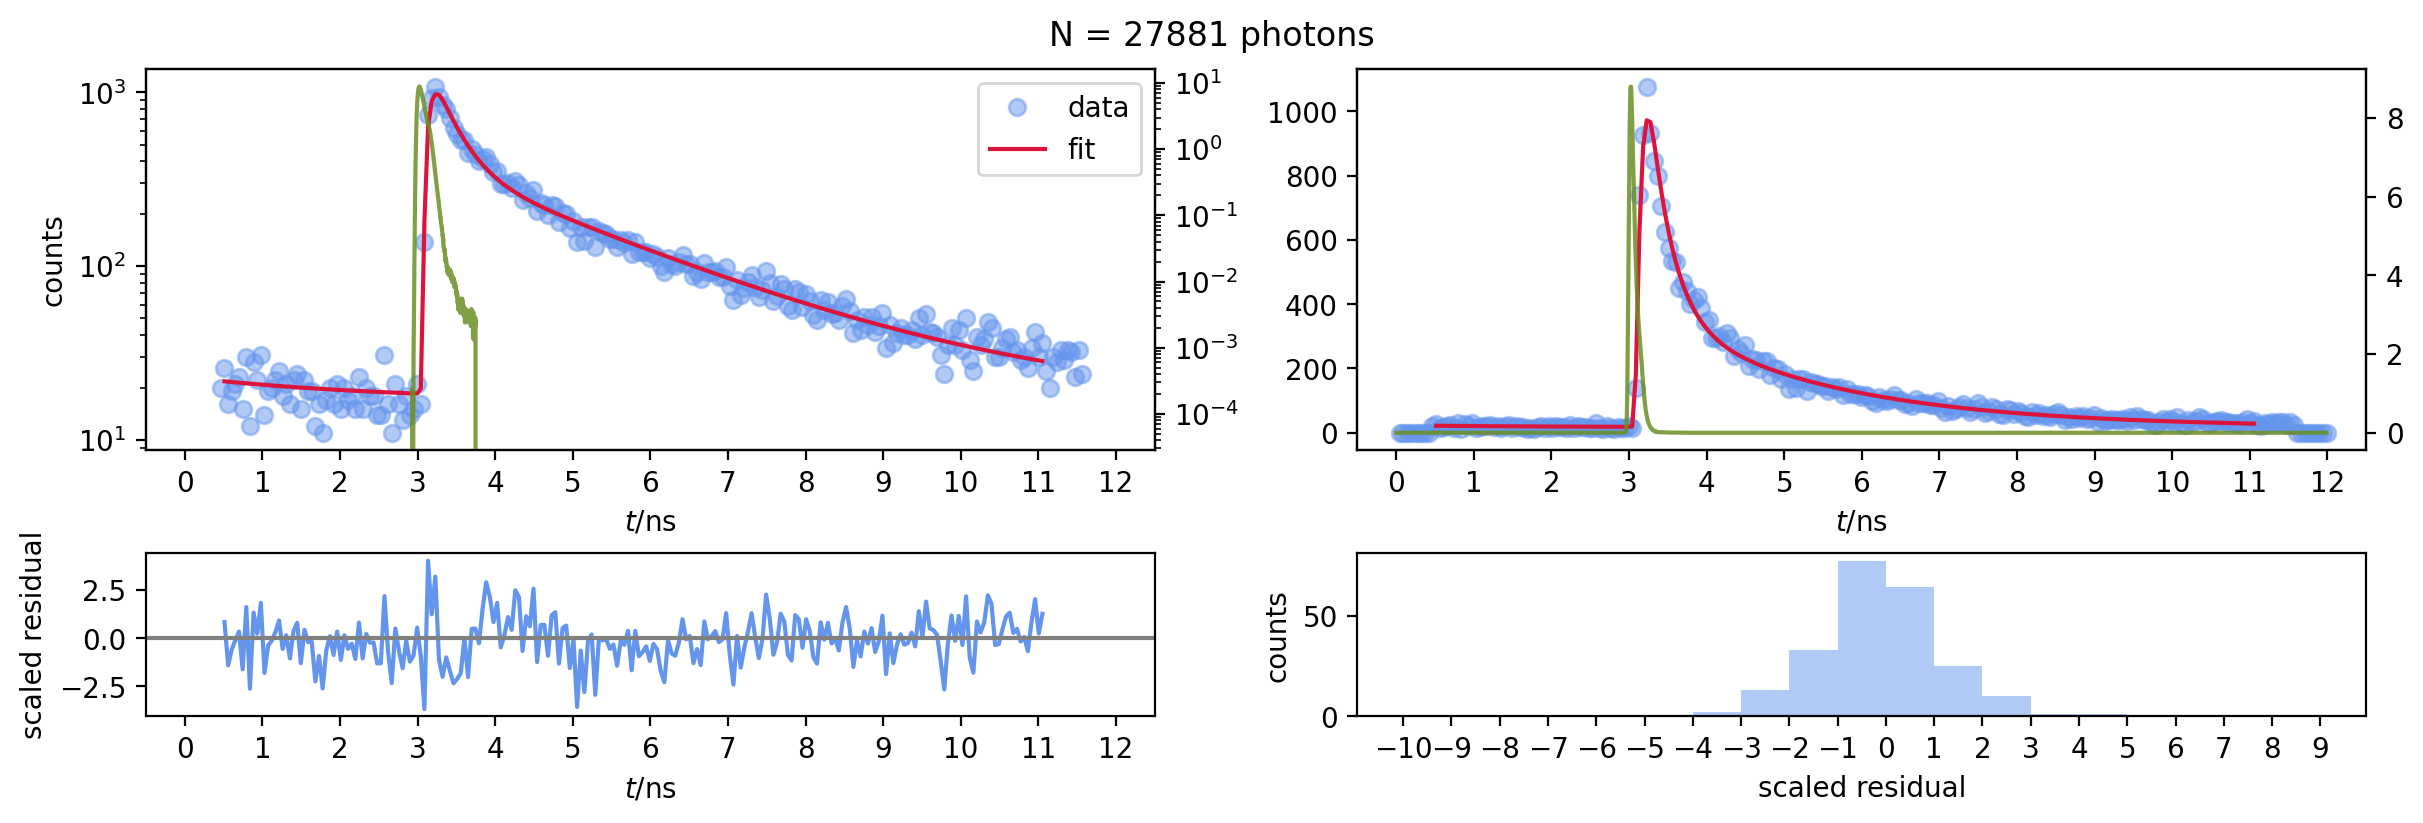

,value,err,min,max,step
shift,22.000,0.425532,-300.00,300.00,1.000
A,0.988,0.000851,0.95,1.00,0.001
tau1,2.280,0.093617,1.50,2.50,0.010
tau2,0.281,0.024255,0.05,0.80,0.001
f,0.267,0.012340,0.10,0.35,0.001


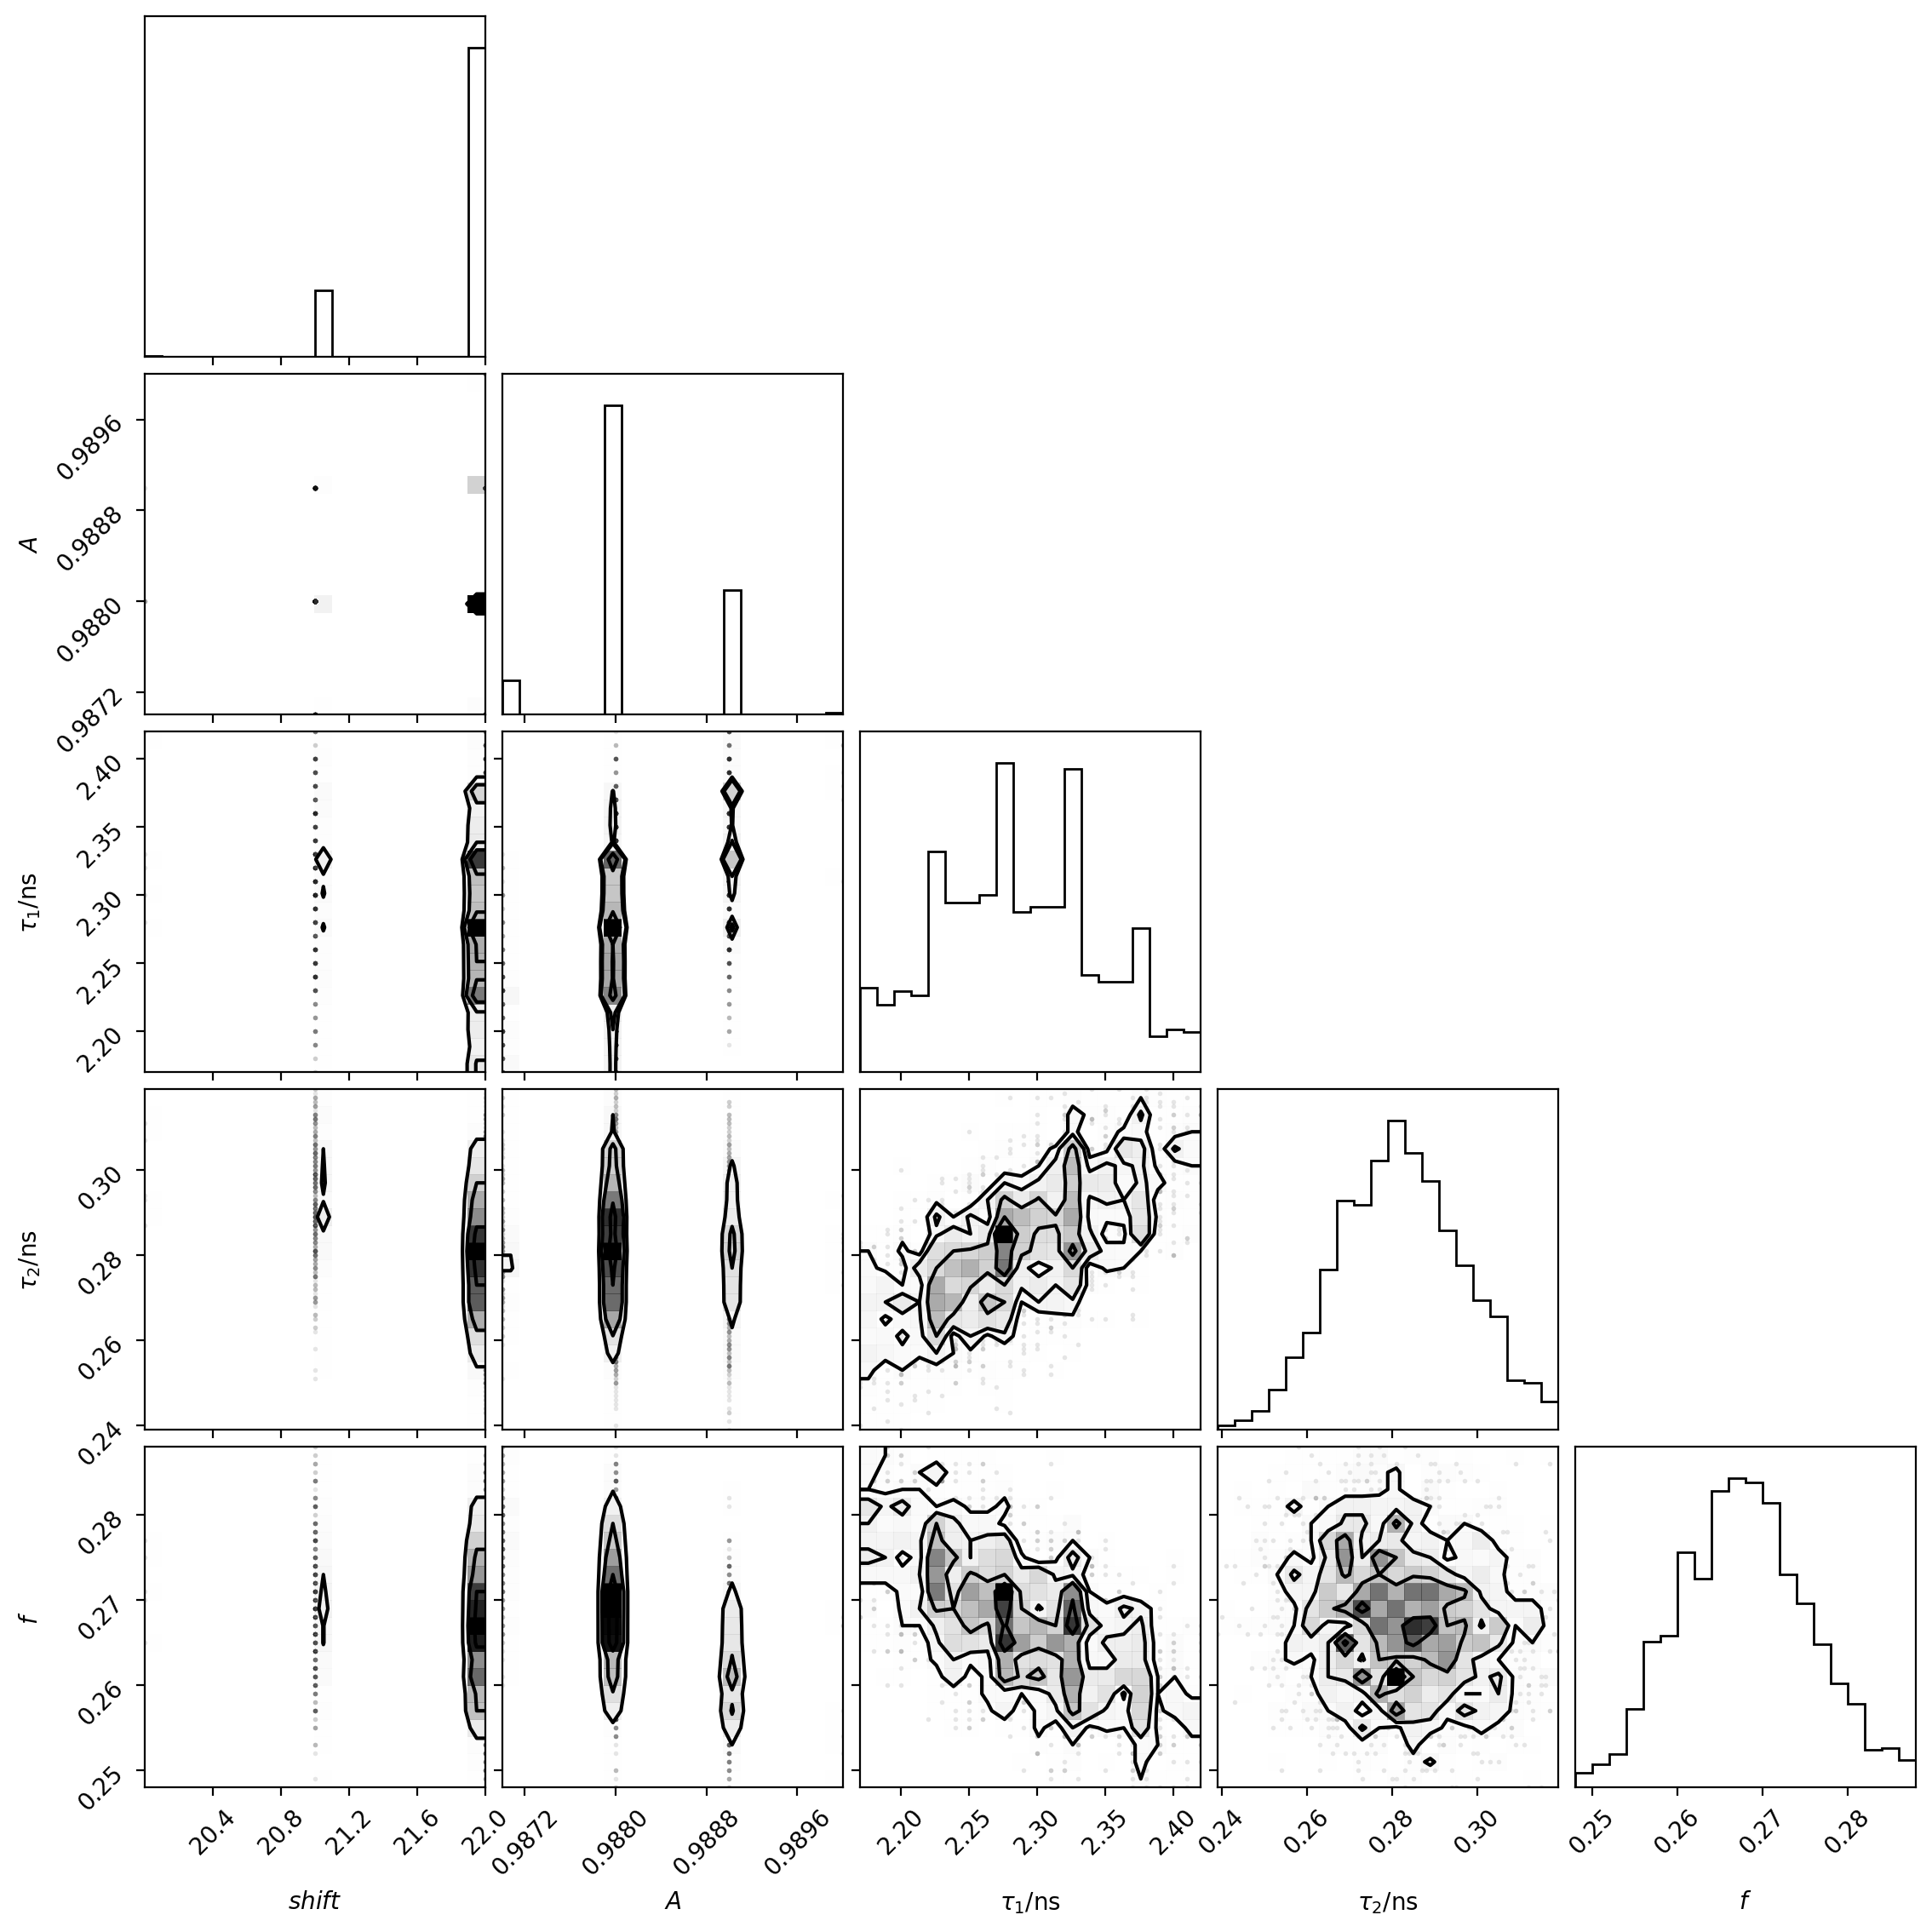

In [17]:
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)

parameters = {
    "shift": {"value": 0    , "err": np.nan, "min": -300 , "max":   300, "step": 1   },
    "A":     {"value": 0.995, "err": np.nan, "min": 0.950, "max": 1.000, "step": 1e-3},
    "tau1":  {"value": 1.8,   "err": np.nan, "min": 1.500, "max": 2.500, "step": 1e-2},
    "tau2":  {"value": 0.25,  "err": np.nan, "min": 0.050, "max": 0.800, "step": 1e-3},
    "f":     {"value": 0.25,  "err": np.nan, "min": 0.100, "max": 0.350, "step": 1e-3},
}

print("least-squares fit:")
fit_result, fit_status = dg.fit(model="2exp", parameters=parameters, plot=True)
display(fit_result)

print("Gibbs sampling:")
fit_result, param_samples = dg.fit(model="2exp", parameters=parameters, plot=True, method="gibbs_sample", method_args=dict(nburn=200, nsample=2000, show_progress=True))
# fit_result, param_samples = dg.fit(model="2exp", parameters=parameters, plot=True, method="gibbs_sample", method_args=dict(nburn=10, nsample=20, show_progress=True))
display(fit_result)

dg.plot_samples()
plt.show()


# fit data from all three z-planes

## 2-exp fit (least squares fit)

In [9]:
df_2exp = pd.DataFrame(columns=["shift", "A", "tau1", "tau2", "f"])

plot=False

cat_probs = np.load("sample_data/p7_z1_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z1.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="2exp", parameters=None, plot=plot)
df_2exp.loc["z1"] = fit_result["value"]

cat_probs = np.load("sample_data/p7_z2_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z2.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="2exp", parameters=None, plot=plot)
df_2exp.loc["z2"] = fit_result["value"]

cat_probs = np.load("sample_data/p7_z3_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z3.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="2exp", parameters=None, plot=plot)
df_2exp.loc["z3"] = fit_result["value"]

df_2exp

,shift,A,tau1,tau2,f
z1,21.524065,0.990828,2.343748,0.306150,0.262494
z2,23.608466,0.991527,2.283704,0.244905,0.246842
z3,22.499997,0.988992,2.284824,0.277929,0.267176


## 3-exp fit (least squares fit)

In [10]:
df_3exp = pd.DataFrame(columns=["shift", "A", "tau1", "tau2", "tau3", "f1", "f2"])

plot=False

cat_probs = np.load("sample_data/p7_z1_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z1.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="3exp", parameters=None, plot=plot)
df_3exp.loc["z1"] = fit_result["value"]

cat_probs = np.load("sample_data/p7_z2_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z2.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="3exp", parameters=None, plot=plot)
df_3exp.loc["z2"] = fit_result["value"]

cat_probs = np.load("sample_data/p7_z3_Probabilities.npy")
use_px = cat_probs[:,:,0] > 0.7
flimg  = pc.load_sdt("sample_data/p7_z3.sdt", use_dask=False).isel(file_info=0).sel(channel="M1")
dc = pc.decay_curve(flimg, mask=use_px)
dg = pc.decay_group(dc, irf.sel(channel="M2"), irf_kws=dc_kwargs_M2, fit_start_bin=10, fit_end_bin=235)
fit_result, fit_status = dg.fit(model="3exp", parameters=None, plot=plot)
df_3exp.loc["z3"] = fit_result["value"]

df_3exp

,shift,A,tau1,tau2,tau3,f1,f2
z1,24.499985,0.996052,3.395235,0.754677,0.107894,0.116070,0.342255
z2,26.499993,0.995439,2.899633,0.594082,0.084576,0.127183,0.297531
z3,25.499997,0.993694,2.799689,0.575478,0.078837,0.138059,0.329982
